In [1]:
import datetime
import itertools
import os
import random
from bisect import bisect_left
from math import hypot
from typing import List, Tuple, Union
import sys
from matplotlib.pyplot import xlabel, xscale
import numpy as np
import pandas as pd

idx = pd.IndexSlice

from utils_ws import *

In [2]:
# Input Parameters
overwrite_pickles = False
wishart_instances = True
save_plots = True
sizes = []
alphas = []

In [3]:
# Specify inputs
# sizes.append(int(str(sys.argv[1])))
# alphas.append(float(str(sys.argv[2])))
# statistic = str(sys.argv[3])
sizes = [50]
alphas = [0.5]
statistic = '50'

In [4]:
# Execute code
# if int(str(sys.argv[2])) == 1:
if 0 == 1:
    ocean_df_flag = True
else:
    ocean_df_flag = False
use_raw_dataframes = False
draw_plots = True

# data_path = "/nobackup/dbernaln/repos/stochastic-benchmark/data/sk/"
# data_path = "/home/bernalde/repos/stochastic-benchmark/data/sk_pleiades/"
# data_path = "/home/bernalde/results_20_0.4"
if len(sizes) == 1 and len(alphas) == 1 and wishart_instances:
    # data_path = "/home/bernalde/results_"+str(sizes[0])+"_"+str(alphas[0])
    data_path = '/home/bernalde/repos/stochastic-benchmark/data/wishart/results_{:.0f}_{:.2f}'.format(
        sizes[0], alphas[0])
    # data_path = '/anvil/scratch/x-bernalde/wishart/results/results_{:.0f}_{:.1f}'.format(sizes[0], alphas[0])

plots_path = os.path.join(data_path, 'plots/')
instances_path = os.path.join(data_path, 'instances/')
if ocean_df_flag:
    results_path = os.path.join(data_path, 'dneal/')
elif wishart_instances:
    # results_path = '/home/bernalde/repos/wishart/scripts/results/results_{:.0f}_{:.1f}'.format(sizes[0], alphas[0])
    # results_path = '/home/bernalde/repos/wishart/scripts/results/results_df'
    results_path = '/home/bernalde/repos/stochastic-benchmark/data/wishart/results_df/'
    # results_path = '/home/bernalde/repos/wishart/scripts/results/results_df/'
    # results_path = '/anvil/scratch/x-bernalde/wishart/results/results_df'
else:
    results_path = os.path.join(data_path, 'pysa/')
pickles_path = os.path.join(results_path, 'pickles')

In [5]:
# Import plotting libraries
if draw_plots:
    import matplotlib.pyplot as plt
    import seaborn as sns
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)

In [6]:
schedules = []
sweeps = []
replicas = []
instances = []
Tcfactors = []
Thfactors = []

# Jobid instances
# Fixed sweep, schedule, Tcfactor, Thfactors
# Input parameter size
schedules = ['geometric']
sweeps = [1000]
replicas = [8]
Tcfactors = [0]
Thfactors = [-1.5]
pcolds = [1.00]
phots = [50.0]


all_sweeps = [1] + [i for i in range(2, 21, 2)] + [
    i for i in range(20, 51, 5)] + [
    i for i in range(50, 101, 10)] + [
    i for i in range(100, 201, 20)] + [
    i for i in range(200, 501, 50)] + [
    i for i in range(500, 1001, 100)]  # + [
# i for i in range(1000, 2001, 200)] + [
# i for i in range(2000, 5001, 500)] + [
# i for i in range(5000, 10001, 1000)]
# sweep_idx = jobid % len(sweeps)
# sweeps.append(all_sweeps[sweep_idx])
sweeps = all_sweeps
replicas = [2**i for i in range(0, 4)]
# replicas.append(int(str(sys.argv[2])))
# instances.append(int(jobid))
# instances = [i for i in range(0, 20)] + [42]
instances = [i for i in range(1, 51)]
# instances = [i for i in range(1,5)]
# training_instances = [i for i in range(0,20)]
# training_instances = instances
training_instances = [i for i in range(1, 41)]
evaluate_instances = [i for i in range(41, 51)]
Tcfactors = [0.0]
Thfactors = list(np.linspace(-3, 1, num=33, endpoint=True))
# Thfactors = [0.0]


EPSILON = 1e-10
confidence_level = 68

bootstrap_iterations = 1000

# Create dictionaries for upper and lower bounds of confidence intervals
metrics = ['min_energy', 'rtt',
           'perf_ratio', 'success_prob', 'mean_time', 'inv_perf_ratio']
lower_bounds = {key: None for key in metrics}
lower_bounds['success_prob'] = 0.0
lower_bounds['mean_time'] = 0.0
lower_bounds['inv_perf_ratio'] = EPSILON
upper_bounds = {key: None for key in metrics}
upper_bounds['success_prob'] = 1.0
upper_bounds['perf_ratio'] = 1.0

In [7]:
# Join all the results in a single dataframe
merge_all_results = False
default_boots = 200
minimum_boots = 1

# Define parameters dict
default_parameters = {
    'sweep': [1000],
    'schedule': ['geometric'],
    'replica': [1],
    'Tcfactor': [0.0],
    'Thfactor': [0.0],
    'pcold': [1.0],
    'phot': [50.0],
    'swe': [1000],
    'rep': [1]
}

if ocean_df_flag:
    parameters_dict = {
        'schedule': schedules,
        'sweep': sweeps,
        'Tcfactor': Tcfactors,
        'Thfactor': Thfactors,
    }
elif wishart_instances:
    parameters_dict = {
        'swe': sweeps,
        'rep': replicas,
        'pcold': pcolds,
        'phot': phots,
    }
else:
    parameters_dict = {
        'sweep': sweeps,
        'replica': replicas,
        'Tcfactor': Tcfactors,
        'Thfactor': Thfactors,
    }
# Add default parametes in case they are missing and remove repeated elements in the parameters_dict values (sets)
if parameters_dict is not None:
    for i, j in parameters_dict.items():
        if len(j) == 0:
            parameters_dict[i] = default_parameters[i]
        else:
            parameters_dict[i] = set(j)
# Create list of parameters
parameter_names = list(parameters_dict.keys())

parameter_sets = itertools.product(
    *(parameters_dict[Name] for Name in parameters_dict))
parameter_sets = list(parameter_sets)

for size in sizes:
    for alpha in alphas:
        # prefix = "random_n_"+str(size)+"_inst_"
        prefix = 'wishart_planting_N_{:.0f}_alpha_{:.2f}_inst_'.format(
            size, alpha)
        df_name_all = prefix + 'df_results.pkl'
        df_path_all = os.path.join(results_path, df_name_all)
        if os.path.exists(df_path_all) and not use_raw_dataframes:
            df_results_all = pd.read_pickle(df_path_all)
        else:
            df_results_all = pd.DataFrame()
            if merge_all_results:
                df_results_list = []
                for instance in instances:
                    df_name = prefix + str(instance) + '_df_results.pkl'
                    df_path = os.path.join(results_path, df_name)
                    df_results_list.append(pd.read_pickle(df_path))
                df_results_all = pd.concat(df_results_list, ignore_index=True)
                df_results_all.to_pickle(df_path_all)
        # Set the parameter sets as those in the results dataframe
        if all(name in df_results_all.columns for name in parameter_names):
            df_results_all['params'] = df_results_all[parameter_names].apply(
                tuple, axis=1)
            parameter_sets = list(set(df_results_all['params'].values))


for size in sizes:
    for alpha in alphas:
        # prefix = "random_n_"+str(size)+"_inst_"
        prefix = 'wishart_planting_N_{:.0f}_alpha_{:.2f}_inst_'.format(
            size, alpha)
        # TODO fix this
        # df_name_stats = prefix + 'all_df_stats_rep0.pkl'
        df_name_stats = prefix + 'all_df_stats.pkl'
        df_path_stats = os.path.join(results_path, df_name_stats)
        if not os.path.exists(df_path_stats):
            df_stats = None
        else:
            df_stats = pd.read_pickle(df_path_stats)
            # TODO This creates the lists only for the last size. Maybe introduce a dictionary instead
            if all(name in df_stats.columns for name in parameter_names):
                df_stats['params'] = df_stats[parameter_names].apply(tuple, axis=1)
                parameter_sets = list(set(df_stats['params'].values))
                stale_parameters = []
                varying_parameters = []
                numeric_parameters = []
                for parameter_name in parameter_names:
                    if df_stats[parameter_name].nunique() == 1:
                        stale_parameters.append(parameter_name)
                    else:
                        varying_parameters.append(parameter_name)
                        if np.issubdtype(df_stats[parameter_name][0], int) or np.issubdtype(df_stats[parameter_name][0], float):
                            numeric_parameters.append(parameter_name)
                included_parameters = df_stats[numeric_parameters].values

In [8]:
# Main execution
generate_interpolated_stats = False
generate_interpolated_results = False
overwrite_pickles = False
resource_column = 'reads'
# resource_proportional_parameters=['sweep', 'replica'],
resource_proportional_parameters = ['swe', 'rep']
# resource_proportional_parameters = ['swe']
# Interpolate results accross resources
for size in sizes:
    for alpha in alphas:
        # prefix = "random_n_"+str(size)+"_inst_"
        prefix = 'wishart_planting_N_{:.0f}_alpha_{:.2f}_inst_'.format(
            size, alpha)
        # TODO fix this
        # df_name_stats = prefix + 'all_df_stats_rep0.pkl'
        df_name_stats = prefix + 'all_df_stats.pkl'
        df_path_stats = os.path.join(results_path, df_name_stats)
        if not os.path.exists(df_path_stats):
            df_stats = None
        else:
            resource_values = gen_log_space(min(df_stats[resource_column].values), max(
                df_stats[resource_column].values), default_boots // 2)
            df_stats_all = pd.read_pickle(df_path_stats)
            df_name_stats_interpolated = df_name_stats.rsplit('.', 1)[
                0] + '_interp.pkl'
            df_path_stats_interpolated = os.path.join(
                results_path, df_name_stats_interpolated)
            if not generate_interpolated_stats:
                if os.path.exists(df_path_stats_interpolated):
                    df_stats_all_interpolated = pd.read_pickle(
                        df_path_stats_interpolated)
                    resource_values = df_stats_all_interpolated[resource_column].values
                else:
                    df_stats_all_interpolated = df_stats.copy()
            else:
                df_stats_all_interpolated = interpolate_df(
                    dataframe=df_stats_all,
                    resource_column=resource_column,
                    prefix=df_name_stats,
                    parameters_dict=parameters_dict,
                    default_boots=default_boots,
                    minimum_boots=minimum_boots,
                    resource_proportional_parameters=resource_proportional_parameters,
                    idx=idx,
                    results_path=results_path,
                    save_pickle=True,
                    overwrite_pickles=overwrite_pickles,
                    resource_values=resource_values,
                )

        # df_name_stats_train = prefix + 'eval_df_stats_rep0.pkl'
        # df_name_stats_eval = prefix + 'train_df_stats_rep0.pkl'
        df_name_stats_train = prefix + 'eval_df_stats.pkl'
        df_name_stats_eval = prefix + 'train_df_stats.pkl'
        # df_name_stats = prefix + 'df_stats.pkl'
        df_path_stats_eval = os.path.join(results_path, df_name_stats_eval)
        df_path_stats_train = os.path.join(results_path, df_name_stats_train)
        if not os.path.exists(df_path_stats_eval) or not os.path.exists(df_path_stats_train):
            df_stats_train = df_stats_all.copy()
            df_stats_eval = df_stats_all.copy()
        else:
            df_stats_eval = pd.read_pickle(df_path_stats)
            df_stats_train = pd.read_pickle(df_path_stats)
            resource_values = gen_log_space(min(df_stats_eval[resource_column].values), max(
                df_stats_eval[resource_column].values), default_boots // 2)
            df_name_stats_interpolated_eval = df_name_stats_eval.rsplit('.', 1)[
                0] + '_interp.pkl'
            df_path_stats_interpolated_eval = os.path.join(
                results_path, df_name_stats_interpolated_eval)
            df_name_stats_interpolated_train = df_name_stats_train.rsplit('.', 1)[
                0] + '_interp.pkl'
            df_path_stats_interpolated_train = os.path.join(
                results_path, df_name_stats_interpolated_train)
            if not generate_interpolated_stats:
                if os.path.exists(df_path_stats_interpolated):
                    df_stats_interpolated_eval = pd.read_pickle(
                        df_path_stats_interpolated_eval)
                    df_stats_interpolated_train = pd.read_pickle(
                        df_path_stats_interpolated_train)
                    resource_values = df_stats_interpolated_eval[resource_column].values
                else:
                    df_stats_interpolated_eval = df_stats_all_interpolated.copy()
                    df_stats_interpolated_train = df_stats_all_interpolated.copy()
            else:
                df_stats_interpolated_eval = interpolate_df(
                    dataframe=df_stats_eval,
                    resource_column=resource_column,
                    prefix=df_name_stats_eval,
                    parameters_dict=parameters_dict,
                    default_boots=default_boots,
                    minimum_boots=minimum_boots,
                    resource_proportional_parameters=resource_proportional_parameters,
                    idx=idx,
                    results_path=results_path,
                    save_pickle=True,
                    overwrite_pickles=overwrite_pickles,
                    resource_values=resource_values,
                )
                df_stats_interpolated_train = interpolate_df(
                    dataframe=df_stats_train,
                    resource_column=resource_column,
                    prefix=df_name_stats_train,
                    parameters_dict=parameters_dict,
                    default_boots=default_boots,
                    minimum_boots=minimum_boots,
                    resource_proportional_parameters=resource_proportional_parameters,
                    idx=idx,
                    results_path=results_path,
                    save_pickle=True,
                    overwrite_pickles=overwrite_pickles,
                    resource_values=resource_values,
                )

        df_name_interpolated = df_name_all.rsplit('.', 1)[0] + '_interp.pkl'
        df_path_interpolated = os.path.join(results_path, df_name_interpolated)
        if not generate_interpolated_results:
            if os.path.exists(df_path_interpolated):
                df_results_interpolated = pd.read_pickle(df_path_interpolated)
            else:
                df_results_interpolated = df_results_all.copy()
        else:
            df_results_interpolated = interpolate_df(
                dataframe=df_results_all,
                resource_column=resource_column,
                prefix=df_name_all,
                parameters_dict=parameters_dict,
                default_boots=default_boots,
                minimum_boots=minimum_boots,
                resource_proportional_parameters=resource_proportional_parameters,
                idx=idx,
                results_path=results_path,
                save_pickle=True,
                overwrite_pickles=overwrite_pickles,
                resource_values=resource_values,
            )
        # df_results_interpolated_train = df_results_interpolated[df_results_interpolated['instance'].isin(training_instances)]
        # df_results_interpolated_eval = df_results_interpolated[df_results_interpolated['instance'].isin(evaluate_instances)]

In [9]:
# Create virtual best and virtual worst columns
# TODO This can be generalized as using as groups the parameters that are not dependent of the metric (e.g., schedule) or that signify different solvers
# TODO This needs to be functionalized
# TODO This is only performed for the last size. Maybe introduce a dictionary instead
use_raw_dataframes = False

response_column = 'perf_ratio'
response_direction = 1
df_name_all = prefix + 'df_results.pkl'
# df_name_all = prefix + 'df_results_rep0.pkl'


df_name_recipe_lazy = df_name_all.rsplit(
    '.', 1)[0] + '_recipe_lazy' + statistic + 'train.pkl'
df_path_recipe_lazy = os.path.join(results_path, df_name_recipe_lazy)
if os.path.exists(df_path_recipe_lazy) and not use_raw_dataframes:
    recipe_lazy = pd.read_pickle(df_path_recipe_lazy)
else:

    # Recipe to obtain parameter setting that optimizes the quantile of the response (across instances) in the statistics dataframe for each read
    recipe_lazy = df_stats_interpolated_train[
        [statistic+'_'+response_column] + parameter_names + ['reads']
    ].set_index(
        parameter_names
    ).groupby(['reads']
              ).idxmax().rename(
        columns={statistic+'_'+response_column: 'recipe'})

    # TODO Explore changing this tolist(), it is faster according to https://stackoverflow.com/questions/29550414/how-can-i-split-a-column-of-tuples-in-a-pandas-dataframe
    recipe_lazy = recipe_lazy.merge(
        recipe_lazy['recipe'].apply(pd.Series).rename(
            columns={i: parameter_names[i]
                     for i in range(len(parameter_names))}
        ).reset_index(),
        on=['reads'],
        how='left')

    recipe_lazy = recipe_lazy.merge(
        df_stats_interpolated_eval[
            [statistic+'_'+response_column] + parameter_names + ['reads']
        ].set_index(
            parameter_names
        ).groupby(['reads']
                  ).max().reset_index(),
        on=['reads'],
        how='left')

    recipe_lazy.to_pickle(df_path_recipe_lazy)


df_name_recipe_mean_best = df_name_all.rsplit(
    '.', 1)[0] + '_recipe_mean_best'+statistic+'train.pkl'
df_path_recipe_mean_best = os.path.join(results_path, df_name_recipe_mean_best)


if os.path.exists(df_path_recipe_mean_best) and not use_raw_dataframes:
    recipe_mean_best_params = pd.read_pickle(df_path_recipe_mean_best)
else:
    # Recipe to obtain parameter setting that optimizes the response  in the results dataframe for each instance and read, then takes the mean of the parameters across instances, for each read.
    # There is an extra projection step into the parameter values
    if resource_column not in df_results_interpolated.columns:
        df_results_interpolated[resource_column] = df_results_interpolated['boots']
        for r_parameters in resource_proportional_parameters:
            if r_parameters in parameter_names:
                df_results_interpolated[resource_column] *= df_results_interpolated[r_parameters]
    mask_instances = df_results_interpolated[
        parameter_names+['instance']
    ].groupby(
        parameter_names
    ).transform('nunique').gt(1).values
    recipe_mean_best_params = df_results_interpolated[mask_instances][
        [response_column] + parameter_names + ['instance'] + [resource_column]
    ].set_index(
        numeric_parameters
    ).groupby(['instance', 'reads']
              )[response_column].idxmax().apply(pd.Series).reset_index().set_index(
        ['instance']
    ).groupby(['reads']
              ).mean().rename(columns={i: numeric_parameters[i] for i in range(len(numeric_parameters))}).reset_index()

    for stale_parameter in stale_parameters:
        recipe_mean_best_params[stale_parameter] = df_results_interpolated[
            stale_parameter][0]

    # Project the numeric parameters in the recipe to the evaluated parameters
    for numeric_parameter in numeric_parameters:
        parameter_list = np.sort(
            df_results_interpolated[numeric_parameter].unique())
        recipe_mean_best_params[numeric_parameter] = recipe_mean_best_params[numeric_parameter].apply(
            lambda x: take_closest(parameter_list, x))

    # # Project the reads to the closest value in boots_list*sweeps
    # recipe_mean_best_params['boots'] = recipe_mean_best_params.index/recipe_mean_best_params['sweeps']
    # recipe_mean_best_params['boots']=recipe_mean_best_params['boots'].apply(lambda x: take_closest(boots_list,x))
    # recipe_mean_best_params.index = recipe_mean_best_params['boots']*recipe_mean_best_params['sweeps']
    # recipe_mean_best_params.index.rename('reads',inplace=True)

    # Join parameters in recipe to single column
    recipe_mean_best_params['params'] = recipe_mean_best_params[parameter_names].apply(
        tuple, axis=1)
    df_results_interpolated['params'] = df_results_interpolated[parameter_names].apply(
        tuple, axis=1)

    # Projecting parameter setting absent in the original dataframe to one that is available using the Euclidean norm.
    # TODO The euclidean norm does not work with non-numerical data
    # TODO performance improvement here. This is by no means efficient.
    # scale = [df_results_interpolated[i].max() - df_results_interpolated[i].min() for i in numeric_parameters]
    scale_dict = {
        'swe': 1,
        'rep': 0.1,
        'pcold': 10,
        'phot': 10,
    }
    scale = [scale_dict[i] for i in numeric_parameters]
    if not all([i in parameter_sets for i in recipe_mean_best_params['params'].values]):
        for index, row in recipe_mean_best_params.iterrows():
            if row['params'] not in set(parameter_sets):
                non_included_parameters = row[numeric_parameters].values
                non_included_parameters = np.array(
                    non_included_parameters, dtype=float)
                print('These parameters are not included in the original database',
                      non_included_parameters)
                projection_parameters = df_stats_interpolated_train[
                    df_stats_interpolated_train['reads'] == row['reads']
                ][numeric_parameters].values
                new_parameters = projection_parameters[
                    np.linalg.norm(
                        (
                            (projection_parameters-non_included_parameters)/scale), axis=1)
                    .argmin()
                ]
                print('Projected parameters as', new_parameters)
                for i, numeric_parameter in enumerate(numeric_parameters):
                    recipe_mean_best_params[numeric_parameter][index] = new_parameters[i]

    # Join parameters in recipe to single column
    recipe_mean_best_params['params'] = recipe_mean_best_params[parameter_names].apply(
        tuple, axis=1)
    recipe_mean_best_params['recipe'] = recipe_mean_best_params[parameter_names + [
        'reads']].apply(tuple, axis=1)

    dummy_df = df_stats_interpolated_eval[
        [statistic+'_'+response_column] + parameter_names + ['reads']
    ].set_index(
        parameter_names + ['reads']
    ).loc[pd.MultiIndex.from_tuples(recipe_mean_best_params['recipe']
                                    )].copy()

    dummy_df.index.rename(parameter_names + ['reads'], inplace=True)

    recipe_mean_best_params = recipe_mean_best_params.merge(
        dummy_df.reset_index()[
            [statistic+'_'+response_column] + ['reads']
        ],
        on=['reads'],
        how='left')

    recipe_mean_best_params.to_pickle(df_path_recipe_mean_best)


df_name_virtual = df_name_all.rsplit('.', 1)[0] + '_virtual'+statistic+'train.pkl'
df_path_virtual = os.path.join(results_path, df_name_virtual)

if os.path.exists(df_path_virtual) and not use_raw_dataframes:
    df_virtual = pd.read_pickle(df_path_virtual)
else:
    # Computation of virtual best perf_ratio as commended by Davide, several points: 1) the perf_ratio is computed as the maximum (we are assuming we care about the max) of for each instance for each read, 2) the quantile of this idealized solver (that has the best parameters for each case) across the instances is computed
    if statistic == 'median':
        percentile = 50
    else:
        percentile = float(statistic)
    # df_virtual = df_virtual.merge(
    if response_direction == -1:  # Minimization
        df_virtual = df_results_interpolated[[response_column] + parameter_names + ['instance', 'reads']].set_index(
            parameter_names
        ).groupby(['instance', 'reads']
                  )[response_column].min().reset_index().set_index(
            ['instance']
        ).groupby(['reads']
                  ).quantile(percentile/100.0).reset_index().sort_values(
            ['reads']).rename(columns={response_column: 'virt_best_'+statistic+'_'+response_column})
    else:  # Maximization
        df_virtual = df_results_interpolated[[response_column] + parameter_names + ['instance', 'reads']].set_index(
            parameter_names
        ).groupby(['instance', 'reads']
                  )[response_column].max().reset_index().set_index(
            ['instance']
        ).groupby(['reads']
                  ).quantile(percentile/100.0).reset_index().sort_values(
            ['reads']).rename(columns={response_column: 'virt_best_'+statistic+'_'+response_column})
        #     ).expanding(min_periods=1).max(),
        # on=['reads'],
        # how='left')
    # TODO Generalize direction of search

    df_virtual = df_virtual.merge(df_results_interpolated_eval[
        [response_column] + parameter_names + ['instance', 'reads']
    ].set_index(
        parameter_names
    ).groupby(['instance', 'reads']
              )[response_column].max().reset_index().set_index(
        ['instance']
    ).groupby(['reads']
              ).max().reset_index().sort_values(
        ['reads']).rename(columns={response_column: 'envelope_'+response_column}),
        on=['reads'],
        how='left')

    df_virtual = df_virtual.merge(
        df_stats_interpolated_eval[
            [statistic+'_'+response_column] + parameter_names + ['reads']
        ].set_index(
            parameter_names
        ).groupby(['reads']
                  ).max().reset_index().rename(columns={statistic+'_perf_ratio': statistic+'_lazy_perf_ratio'}))

    dummy_df = df_stats_interpolated_eval[
        [statistic+'_'+response_column] + parameter_names + ['reads']
    ].set_index(
        parameter_names + ['reads']
    ).loc[pd.MultiIndex.from_tuples(recipe_mean_best_params['recipe']
                                    )].copy()

    dummy_df.index.rename(parameter_names + ['reads'], inplace=True)

    df_virtual = df_virtual.merge(
        dummy_df.reset_index()[
            [statistic+'_'+response_column] + ['reads']
        ],
        on=['reads'],
        how='left')

    df_virtual.to_pickle(df_path_virtual)

In [10]:
# Random search for the ensemble
repetitions = 10  # Times to run the algorithm
# # resources per parameter setting (reads/resource_factor = boots)
# rs = [10, 20, 50, 100, 200, 500, 1000]
# resources per parameter setting (reads)
rs_o = [10, 20, 50, 100, 200, 500, 1000, 10000]
rs = [take_closest(resource_values, r) for r in rs_o]
df_stats_interps = [df_stats_interpolated_train, df_stats_interpolated_eval]
for df_stats_interp in df_stats_interps:
    if 'params' not in df_stats_interp:
        df_stats_interp['params'] = df_stats_interp[parameter_names].apply(
            tuple, axis=1)

frac_r_exploration = [0.05, 0.1, 0.2, 0.5, 0.75]
R_budgets = [i*10**j for i in [1, 1.5, 2, 3, 5, 7]
             for j in [3, 4, 5]] + [1e6]  # Total search budget (reads)
experiments = rs * repetitions
df_progress_name = df_name_all.rsplit(
    '.', 1)[0] + '_progress_binary'+statistic+'train.pkl'
df_progress_path = os.path.join(results_path, df_progress_name)
df_progress_end_path = os.path.join(
    results_path, df_progress_name.rsplit('.', 1)[0] + '_end.pkl')
search_metric = statistic+'_'+response_column
compute_metric = statistic+'_'+response_column
df_search = df_stats_interpolated_train[
    parameter_names +
    list(set([compute_metric] + [search_metric])) + ['reads']
].set_index(
    parameter_names + ['reads']
).sort_index()
df_reads = df_stats_interpolated_train[
    parameter_names + ['reads']
].set_index(
    parameter_names
).sort_index()

maximum_boots = max(default_boots, df_stats_interpolated_train['boots'].max())

r_indices = []
# resource_proportional_parameters = ['sweep', 'replica']
resource_proportional_parameters = ['swe', 'rep']
# resource_proportional_parameters = ['swe']
for r_parameters in resource_proportional_parameters:
    if r_parameters in parameter_names:
        r_indices.append(parameter_names.index(r_parameters))
use_raw_dataframes = False
if os.path.exists(df_progress_end_path) and not use_raw_dataframes:
    df_progress_total = None
    df_progress_end = pd.read_pickle(df_progress_end_path)
elif os.path.exists(df_progress_path) and not use_raw_dataframes:
    df_progress_total = pd.read_pickle(df_progress_path)
else:
    progress_list = []
    for R_budget in R_budgets:
        for frac_expl_total in frac_r_exploration:
            # budget for exploration (runs)
            R_exploration = int(R_budget*frac_expl_total)
            # budget for exploitation (runs)
            R_exploitation = R_budget - R_exploration
            for r in rs:
                if r > R_exploration:
                    print(
                        "R_exploration must be larger than single exploration step")
                    continue
                parameter_sets = df_stats_interpolated_train[df_stats_interpolated_train['reads']
                                                             == r]['params'].values
                if len(parameter_sets) == 0:
                    print("No parameter sets found with {} reads".format(r))
                    continue
                for experiment in range(repetitions):
                    random_parameter_sets = random.choices(
                        parameter_sets, k=int(R_exploration / r))
                    # Conservative estimate of very unlikely scenario that we choose all sweeps=1
                    # % Question: Should we replace these samples? We are replacing now

                    all_reads = df_reads.loc[
                        idx[random_parameter_sets[0]]
                    ]
                    resource_factor = 1
                    for r_index in r_indices:
                        resource_factor *= random_parameter_sets[0][r_index]
                    # actual_reads = take_closest(
                    #     all_reads.values, r*resource_factor)[0]
                    actual_reads = r
                    # Start random exploration with best found point
                    series_list = [
                        df_search.loc[idx[random_parameter_sets[0]+((actual_reads),)]]]
                    total_reads = actual_reads

                    if total_reads > R_exploration:
                        # TODO: There should be a better way of having parameters that affect runtime making an appear. An idea, having a function f(params) = runs that we can call
                        print(
                            "R_exploration must be larger than single exploration step")
                        continue

                    for random_parameter_set in random_parameter_sets:
                        resource_factor = 1
                        for r_index in r_indices:
                            resource_factor *= random_parameter_set[r_index]
                        if resource_factor > r:
                            continue
                        if resource_factor*maximum_boots < r:
                            continue
                        # total_reads += r*resource_factor
                        total_reads += r
                        if total_reads > R_exploration:
                            converged = True
                            break
                        series_list.append(
                            df_search.loc[
                                idx[random_parameter_set + (r,)]
                            ]
                        )
                    exploration_step = pd.concat(series_list, axis=1).T.rename_axis(
                        parameter_names + ['reads'])
                    exploration_step[compute_metric] = exploration_step[compute_metric].expanding(
                        min_periods=1).max()
                    exploration_step.reset_index('reads', inplace=True)
                    exploration_step['experiment'] = experiment
                    exploration_step['tau'] = r
                    exploration_step['R_explor'] = R_exploration
                    exploration_step['R_exploit'] = R_exploitation
                    exploration_step['R_budget'] = R_budget
                    exploration_step['cum_reads'] = exploration_step.groupby('experiment').expanding(
                        min_periods=1)['reads'].sum().reset_index(drop=True).values
                    progress_list.append(exploration_step)
                    # Exploitation step
                    exploitation_step = df_search.reset_index().set_index(
                        parameter_names).loc[exploration_step.nlargest(1, compute_metric).index]
                    exploitation_step['cum_reads'] = exploitation_step['reads'] + \
                        exploration_step['cum_reads'].max()
                    exploitation_step.sort_values(['cum_reads'], inplace=True)
                    exploitation_step = exploitation_step[exploitation_step['cum_reads'] <= R_budget]
                    exploitation_step[compute_metric].fillna(
                        0, inplace=True)
                    exploitation_step[compute_metric].clip(
                        lower=exploration_step[compute_metric].max(), inplace=True)
                    exploitation_step[compute_metric] = exploitation_step[compute_metric].expanding(
                        min_periods=1).max()
                    exploitation_step['experiment'] = experiment
                    exploitation_step['tau'] = r
                    exploitation_step['R_explor'] = R_exploration
                    exploitation_step['R_exploit'] = R_exploitation
                    exploitation_step['R_budget'] = R_budget
                    progress_list.append(exploitation_step)
    df_progress_total = pd.concat(progress_list, axis=0)
    df_progress_total.reset_index(inplace=True)
    df_progress_total['f_explor'] = df_progress_total['R_explor'] / \
        df_progress_total['R_budget']
    df_progress_total.to_pickle(df_progress_path)
# for stat_measure in ['median']:
#     if 'best_' + stat_measure + '_perf_ratio' not in df_progress_total.columns:
#         df_progress_total[stat_measure + '_inv_perf_ratio'] = 1 - \
#             df_progress_total[stat_measure + '_perf_ratio'] + EPSILON
#         df_progress_total['best_' + stat_measure + '_inv_perf_ratio'] = df_progress_total.sort_values(
#             ['cum_reads', 'R_budget']
#         ).expanding(min_periods=1).min()[stat_measure + '_inv_perf_ratio']
#         df_progress_total['best_' + stat_measure + '_perf_ratio'] = 1 - \
#             df_progress_total['best_' + stat_measure +
#                               '_inv_perf_ratio'] + EPSILON
# df_progress_total = cleanup_df(df_progress_total)
# df_progress_total.to_pickle(df_path)

In [11]:
df_progress_best, df_progress_end = process_df_progress(
    df_progress=df_progress_total,
    compute_metrics=[statistic+'_perf_ratio'],
    stat_measures=['mean'],
    maximizing=True,
    results_path=results_path,
    use_raw_dataframes=use_raw_dataframes,
    df_progress_name=df_progress_name,
    save_pickle=True,
)
# # %%
# # Ternary search in the ensemble
# # rs = [1, 5, 10]  # resources per parameter setting (runs)
# # rs = [1, 5, 20, 50, 100]  # resources per parameter setting (runs)
# # frac_r_exploration = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
# # frac_r_exploration = [0.05, 0.1, 0.2, 0.5, 0.75]
# # R_budgets = [1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6]
# # R_budgets = [1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6]
# experiments = rs * repetitions
# df_progress_ternary_name = df_name_all.rsplit('.',1)[0] + '_progress_ternary'+statistic+'.pkl'
# df_progress_ternary_path = os.path.join(results_path, df_progress_ternary_name)
# use_raw_dataframes = False
# if os.path.exists(df_progress_ternary_path) and not use_raw_dataframes:
#     df_progress_total_ternary = pd.read_pickle(df_progress_ternary_path)
# else:
#     progress_list = []
#     for R_budget in R_budgets:
#         # for R_budget in [1e4]:
#         for frac_expl_total in frac_r_exploration:
#             # for frac_expl_total in [0.25, 0.5]:
#             # budget for exploration (runs)
#             R_exploration = int(R_budget*frac_expl_total)
#             # budget for exploitation (runs)
#             R_exploitation = R_budget - R_exploration
#             for r in rs:
#                 # for r in [10]:
#                 series_list = []
#                 # Dictionaries containing the parameters indices
#                 up = dict.fromkeys(numeric_parameters)
#                 lo = dict.fromkeys(numeric_parameters)
#                 val_up = dict.fromkeys(numeric_parameters)
#                 val_lo = dict.fromkeys(numeric_parameters)
#                 x1 = dict.fromkeys(numeric_parameters)
#                 x2 = dict.fromkeys(numeric_parameters)
#                 val_x1 = dict.fromkeys(numeric_parameters)
#                 val_x2 = dict.fromkeys(numeric_parameters)
#                 param_lists = dict.fromkeys(numeric_parameters)
#                 numeric_indices = dict.fromkeys(numeric_parameters)
#                 for numeric_parameter in numeric_parameters:
#                     numeric_indices[numeric_parameter] = parameter_names.index(
#                         numeric_parameter)
#                     param_lists[numeric_parameter] = list(
#                         df_results_interpolated[numeric_parameter].unique())
#                     param_lists[numeric_parameter].sort()
#                     if numeric_parameter == 'Thfactor':
#                         # Workaround for incomplete experiments, setting index to 24 in Thfactor such that it is always zero
#                         up[numeric_parameter] = param_lists[numeric_parameter].index(
#                             0.0)
#                         lo[numeric_parameter] = param_lists[numeric_parameter].index(
#                             0.0)
#                     else:
#                         up[numeric_parameter] = len(
#                             param_lists[numeric_parameter]) - 1
#                         lo[numeric_parameter] = 0
#                     val_up[numeric_parameter] = param_lists[numeric_parameter][up[numeric_parameter]]
#                     val_lo[numeric_parameter] = param_lists[numeric_parameter][lo[numeric_parameter]]

#                 resource_factor = 1
#                 ternary_parameter_set_lo = [0]*len(parameter_names)
#                 for i, parameter_name in enumerate(parameter_names):
#                     if parameter_name in numeric_parameters:
#                         ternary_parameter_set_lo[i] = val_lo[parameter_name]
#                     else:
#                         # Taking the first element of the not numeric parameters assuming they are stale
#                         ternary_parameter_set_lo[i] = df_results_interpolated[parameter_name][0]
#                     if parameter_name in resource_proportional_parameters:
#                         resource_factor *= val_lo[parameter_name]

#                 perf_lo = df_search.loc[
#                     idx[tuple(ternary_parameter_set_lo) + (r,)
#                         ]][compute_metric]

#                 total_reads = r*resource_factor
#                 if total_reads > R_exploration:
#                     print(
#                         "R_exploration must be larger than the first exploration step")
#                     continue
#                 series_list.append(df_search.loc[
#                     idx[tuple(ternary_parameter_set_lo) + (r,)
#                         ]])

#                 # First step (before first exploration)
#                 first_step = df_search.reset_index().set_index(
#                     parameter_names).loc[tuple(ternary_parameter_set_lo)].copy()
#                 first_step['cum_reads'] = first_step['reads']
#                 first_step.sort_values(['cum_reads'], inplace=True)
#                 first_step = first_step[first_step['cum_reads']
#                                         <= total_reads].copy()
#                 first_step[compute_metric].fillna(
#                     0, inplace=True)
#                 first_step['tau'] = r
#                 first_step['R_explor'] = R_exploration
#                 first_step['R_exploit'] = R_exploitation
#                 first_step['R_budget'] = R_budget
#                 progress_list.append(first_step)

#                 ternary_parameter_set_x1 = ternary_parameter_set_lo.copy()
#                 ternary_parameter_set_x2 = ternary_parameter_set_lo.copy()
#                 ternary_parameter_set_up = ternary_parameter_set_lo.copy()

#                 for numeric_parameter in numeric_parameters:
#                     ternary_parameter_set_up[numeric_indices[numeric_parameter]
#                                              ] = val_up[numeric_parameter]
#                 for r_index in r_indices:
#                     resource_factor *= ternary_parameter_set_up[r_index]

#                 perf_up = df_search.loc[
#                     idx[tuple(ternary_parameter_set_up) + (r,)
#                         ]][compute_metric]

#                 total_reads += r*resource_factor
#                 if total_reads > R_exploration:
#                     print(
#                         "R_exploration must be larger than the first two exploration steps")
#                 else:
#                     series_list.append(df_search.loc[
#                         idx[tuple(ternary_parameter_set_up) + (r,)
#                             ]])

#                     while any([lo[i] <= up[i] for i in lo.keys()]):
#                         # print([(val_lo[i], val_x1[i], val_x2[i], val_up[i]) for i in lo.keys()])
#                         if total_reads > R_exploration:
#                             break
#                         for numeric_parameter in numeric_parameters:
#                             if numeric_parameter == 'Thfactor':
#                                 continue
#                             if lo[numeric_parameter] > up[numeric_parameter]:
#                                 continue
#                             x1[numeric_parameter] = int(
#                                 lo[numeric_parameter] + (up[numeric_parameter] - lo[numeric_parameter]) / 3)
#                             x2[numeric_parameter] = int(
#                                 up[numeric_parameter] - (up[numeric_parameter] - lo[numeric_parameter]) / 3)
#                             val_x1[numeric_parameter] = param_lists[numeric_parameter][x1[numeric_parameter]]

#                             resource_factor = 1
#                             ternary_parameter_set_x1[numeric_indices[numeric_parameter]
#                                                      ] = val_x1[numeric_parameter]
#                             for r_index in r_indices:
#                                 resource_factor *= ternary_parameter_set_x1[r_index]
#                             perf_x1 = df_search.loc[
#                                 idx[tuple(ternary_parameter_set_x1) + (r,)
#                                     ]][search_metric]

#                             total_reads += r*resource_factor
#                             if total_reads > R_exploration:
#                                 break
#                             series_list.append(df_search.loc[
#                                 idx[tuple(ternary_parameter_set_x1) + (r,)
#                                     ]])
#                             val_x2[numeric_parameter] = param_lists[numeric_parameter][x2[numeric_parameter]]

#                             ternary_parameter_set_x2[numeric_indices[numeric_parameter]
#                                                      ] = val_x2[numeric_parameter]
#                             for r_index in r_indices:
#                                 resource_factor *= ternary_parameter_set_x2[r_index]

#                             perf_x2 = df_search.loc[
#                                 idx[tuple(ternary_parameter_set_x2) + (r,)
#                                     ]][search_metric]

#                             total_reads += r*resource_factor
#                             if total_reads > R_exploration:
#                                 break
#                             series_list.append(df_search.loc[
#                                 idx[tuple(ternary_parameter_set_x2) + (r,)
#                                     ]])
#                             if perf_x2 == perf_up:
#                                 up[numeric_parameter] -= 1
#                                 val_up[numeric_parameter] = param_lists[numeric_parameter][up[numeric_parameter]]
#                                 ternary_parameter_set_up[numeric_indices[numeric_parameter]
#                                                          ] = val_up[numeric_parameter]
#                                 for r_index in r_indices:
#                                     resource_factor *= ternary_parameter_set_up[r_index]
#                                 perf_up = df_search.loc[
#                                     idx[tuple(ternary_parameter_set_up) + (r,)
#                                         ]][search_metric]
#                                 total_reads += r*resource_factor
#                                 if total_reads > R_exploration:
#                                     break
#                                 series_list.append(df_search.loc[
#                                     idx[tuple(ternary_parameter_set_up) + (r,)
#                                         ]])
#                             elif perf_x1 == perf_lo:
#                                 lo[numeric_parameter] += 1
#                                 val_lo[numeric_parameter] = param_lists[numeric_parameter][lo[numeric_parameter]]
#                                 ternary_parameter_set_lo[numeric_indices[numeric_parameter]
#                                                          ] = val_lo[numeric_parameter]
#                                 for r_index in r_indices:
#                                     resource_factor *= ternary_parameter_set_lo[r_index]
#                                 perf_lo = df_search.loc[
#                                     idx[tuple(ternary_parameter_set_lo) + (r,)
#                                         ]][search_metric]
#                                 total_reads += r*resource_factor
#                                 if total_reads > R_exploration:
#                                     break
#                                 series_list.append(df_search.loc[
#                                     idx[tuple(ternary_parameter_set_lo) + (r,)
#                                         ]])
#                             elif perf_x1 > perf_x2:
#                                 up[numeric_parameter] = x2[numeric_parameter]
#                                 val_up[numeric_parameter] = param_lists[numeric_parameter][up[numeric_parameter]]
#                                 ternary_parameter_set_up[numeric_indices[numeric_parameter]
#                                                          ] = val_up[numeric_parameter]
#                                 perf_up = df_search.loc[
#                                     idx[tuple(ternary_parameter_set_up) + (r,)
#                                         ]][search_metric]
#                             else:
#                                 lo[numeric_parameter] = x1[numeric_parameter]
#                                 val_lo[numeric_parameter] = param_lists[numeric_parameter][lo[numeric_parameter]]
#                                 ternary_parameter_set_lo[numeric_indices[numeric_parameter]
#                                                          ] = val_lo[numeric_parameter]
#                                 perf_lo = df_search.loc[
#                                     idx[tuple(ternary_parameter_set_lo) + (r,)
#                                         ]][search_metric]

#                 exploration_step = pd.concat(series_list, axis=1).T.rename_axis(
#                     parameter_names + ['boots'])
#                 exploration_step[compute_metric] = exploration_step[compute_metric].expanding(
#                     min_periods=1).max()
#                 exploration_step.reset_index('boots', inplace=True)
#                 exploration_step['tau'] = r
#                 exploration_step['R_explor'] = R_exploration
#                 exploration_step['R_exploit'] = R_exploitation
#                 exploration_step['R_budget'] = R_budget
#                 exploration_step['cum_reads'] = exploration_step.expanding(
#                     min_periods=1)['reads'].sum().reset_index(drop=True).values
#                 progress_list.append(exploration_step)

#                 exploitation_step = df_search.reset_index().set_index(
#                     parameter_names).loc[exploration_step.nlargest(1, compute_metric).index].copy()
#                 exploitation_step['cum_reads'] = exploitation_step['reads'] + \
#                     exploration_step['cum_reads'].max()
#                 exploitation_step.sort_values(['cum_reads'], inplace=True)
#                 exploitation_step = exploitation_step[exploitation_step['cum_reads'] < R_budget].copy(
#                 )
#                 exploitation_step[compute_metric].fillna(
#                     0, inplace=True)
#                 exploitation_step[compute_metric].clip(
#                     lower=exploration_step[compute_metric].max(), inplace=True)
#                 exploitation_step[compute_metric] = exploitation_step[compute_metric].expanding(
#                     min_periods=1).max()
#                 exploitation_step['tau'] = r
#                 exploitation_step['R_explor'] = R_exploration
#                 exploitation_step['R_exploit'] = R_exploitation
#                 exploitation_step['R_budget'] = R_budget
#                 progress_list.append(exploitation_step)
#     df_progress_total_ternary = pd.concat(progress_list, axis=0)
#     df_progress_total_ternary.reset_index(inplace=True)
#     df_progress_total['f_explor'] = df_progress_total['R_explor'] / \
#         df_progress_total['R_budget']
#     df_progress_total_ternary.to_pickle(df_progress_ternary_path)


# # %%
# df_progress_best_ternary, df_progress_end_ternary = process_df_progress(
#     df_progress=df_progress_total_ternary,
#     compute_metrics=[statistic+'_perf_ratio'],
#     stat_measures=['mean'],
#     maximizing=True,
# results_path=results_path,
# use_raw_dataframes=use_raw_dataframes,
# df_progress_name=df_progress_name,
# save_pickle=True,
# )

In [12]:
print(datetime.datetime.now())

2022-07-15 13:45:04.670265


In [13]:
# Define parameters labels
s = 0.99
gap = 1
labels = {
    'N': 'Number of variables',
    'instance': 'Random instance',
    'replica': 'Number of replicas',
    'sweep': 'Number of sweeps',
    'rep': 'Number of replicas',
    'swe': 'Number of sweeps',
    'pcold': 'Probability of dEmin flip at cold temperature',
    'phot': 'Probability of dEmax flip at hot temperature',
    'Tcfactor': 'Cold temperature power of 10 factor from mean field deviation,  \n 10**Tcfactor*dEmin/log(100/1)',
    'Thfactor': 'Hot temperature power of 10 factor from mean field deviation,  \n 10**Tcfactor*dEmax/log(100/50)',
    'mean_time': 'Mean time [us]',
    'success_prob': 'Success probability \n (within ' + str(gap) + '% of best found)',
    'median_success_prob': 'Success probability \n (within ' + str(gap) + '% of best found)',
    'mean_success_prob': 'Success probability \n (within ' + str(gap) + '% of best found)',
    'perf_ratio': 'Performance ratio \n (random - best found) / (random - min)',
    'best_perf_ratio': 'Performance ratio \n (random - best found) / (random - min)',
    'median_perf_ratio': 'Performance ratio \n (random - best found) / (random - min)',
    'mean_perf_ratio': 'Performance ratio \n (random - best found) / (random - min)',
    'median_mean_perf_ratio': 'Performance ratio \n (random - best found) / (random - min)',
    'mean_mean_perf_ratio': 'Performance ratio \n (random - best found) / (random - min)',
    'median_median_perf_ratio': 'Performance ratio \n (random - best found) / (random - min)',
    'mean_median_perf_ratio': 'Performance ratio \n (random - best found) / (random - min)',
    'rtt': 'TTS ' + str(100*s) + '% confidence  \n (within ' + str(gap) + '% of best found) [s]',
    'median_rtt': 'TTS ' + str(100*s) + '% confidence  \n (within ' + str(gap) + '% of best found) [s]',
    'mean_rtt': 'TTS ' + str(100*s) + '% confidence  \n (within ' + str(gap) + '% of best found) [s]',
    'boots': 'Number of downsamples during bootrapping',
    'reads': 'Total number of reads (proportional to time)',
    'cum_reads': 'Total number of reads (proportional to time)',
    'mean_cum_reads': 'Total number of reads (proportional to time)',
    'min_energy': 'Minimum energy found',
    'mean_time': 'Mean time [us]',
    'Tfactor': 'Factor to multiply lower temperature by',
    'experiment': 'Experiment',
    'inv_perf_ratio': 'Inverse performance ratio \n (best found  - min) / (random - min) + ' + str(EPSILON),
    'median_inv_perf_ratio': 'Inverse performance ratio \n (best found  - min) / (random - min) + ' + str(EPSILON),
    'mean_inv_perf_ratio': 'Inverse performance ratio \n (best found  - min) / (random - min) + ' + str(EPSILON),
    'median_mean_inv_perf_ratio': 'Inverse performance ratio \n (best found  - min) / (random - min) + ' + str(EPSILON),
    'median_median_inv_perf_ratio': 'Inverse performance ratio \n (best found  - min) / (random - min) + ' + str(EPSILON),
    'mean_mean_inv_perf_ratio': 'Inverse performance ratio \n (best found  - min) / (random - min) + ' + str(EPSILON),
    'mean_median_inv_perf_ratio': 'Inverse performance ratio \n (best found  - min) / (random - min) + ' + str(EPSILON),
    'best_inv_perf_ratio': 'Inverse performance ratio \n (best found  - min) / (random - min) + ' + str(EPSILON),
}

<ipython-input-14-26a40282fc73>:136: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  hyperopt_expl_expl = pd.concat([hyperopt_expl_expl.set_index(['R_budget']),max_performance]).min(level=0).reset_index().rename(columns={'index':'R_budget'})
<ipython-input-14-26a40282fc73>:136: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  hyperopt_expl_expl = pd.concat([hyperopt_expl_expl.set_index(['R_budget']),max_performance]).min(level=0).reset_index().rename(columns={'index':'R_budget'})


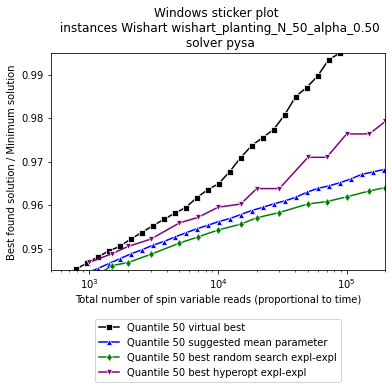

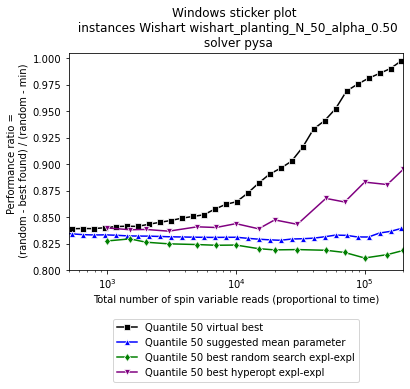

In [14]:
# Windows Stickers Plot
min_plot_reads = 5e2
max_plot_reads = 2e5
if draw_plots:
    for scaling_random in [False,True]:
    # scaling_random = False
        # hyperopt_profiles_path = '/home/bernalde/repos/wishart/scripts/processed/hyperopt_trials/'
        hyperopt_profiles_path = '/home/bernalde/repos/stochastic-benchmark/data/wishart/'
        hyperopt_trials_name = "hyperopt_perf_ratio_" + \
            str(size) + "_" + str(alpha) + ".pkl"
        hyperopt_expl_name = "hyperopt_expl_expl_perf_ratio_" + \
            str(size) + "_" + str(alpha) + ".pkl"

        random_name = 'wishart_planting_N_{:.0f}_alpha_{:.2f}_inst_eval_df_stats_random.pkl'.format(size, alpha)
        hyperopt_path = os.path.join(hyperopt_profiles_path, hyperopt_trials_name)
        hyperopt_expl_path = os.path.join(hyperopt_profiles_path, hyperopt_expl_name)
        random_path = os.path.join(results_path, random_name)
        # Windows sticker plot with virtual best, suggested parameters, best from TTS, default parameters, random search, and ternary search
        fig, ax = plt.subplots()
        
        if os.path.exists(random_path):
            random_perf = pd.read_pickle(random_path)
            
            random_perf = random_perf[['reads', str(int(statistic)) + '_perf_ratio']].set_index('reads').expanding(min_periods=1).max().reset_index().copy()
        
        if scaling_random:  
            # In order to scale the performnace by the random search we take perf_ratio = (random - best_found) / (random - min) = (random_perf - best_found_perf) / (1-random_perf)
            scaling_factors = random_perf.set_index('reads')[[str(int(statistic)) + '_perf_ratio']].copy()
            reads_to_interp = list(df_virtual['reads'].values)
            scaling_factors_virtual = interp(scaling_factors, reads_to_interp)
            df_virtual['virt_best_'+statistic+'_perf_ratio_scaled'] = np.divide(
                scaling_factors_virtual[str(int(statistic)) + '_perf_ratio'].values - df_virtual['virt_best_'+statistic+'_perf_ratio'],
                scaling_factors_virtual[str(int(statistic)) + '_perf_ratio'].values - 1
                )

            df_virtual[statistic+'_lazy_perf_ratio_scaled'] = np.divide(
                scaling_factors_virtual[str(int(statistic)) + '_perf_ratio'].values - df_virtual[statistic+'_lazy_perf_ratio'],
                scaling_factors_virtual[str(int(statistic)) + '_perf_ratio'].values - 1
                )
            sns.lineplot(x='reads', y='virt_best_'+statistic+'_perf_ratio_scaled', data=df_virtual,
                        ax=ax, estimator=None, label='Quantile '+statistic+' virtual best', marker='s', color = 'k')
            sns.lineplot(x='reads', y=statistic+'_lazy_perf_ratio_scaled', data=df_virtual,
                        ax=ax, estimator=None, label='Quantile '+statistic+' suggested mean parameter', marker='^', color='b')
        else:
            # sns.lineplot(x='reads', y=str(int(statistic)) + '_perf_ratio', data=random_perf,
            #              ax=ax, estimator=None, label='Quantile '+statistic+' random', marker='v', color='red')
            sns.lineplot(x='reads', y='virt_best_'+statistic+'_perf_ratio', data=df_virtual,
                        ax=ax, estimator=None, label='Quantile '+statistic+' virtual best', marker='s', color = 'k')
            sns.lineplot(x='reads', y=statistic+'_lazy_perf_ratio', data=df_virtual,
                        ax=ax, estimator=None, label='Quantile '+statistic+' suggested mean parameter', marker='^', color='b')
        default_params = []
        if parameters_dict is not None:
            for i, j in parameters_dict.items():
                default_params.append(default_parameters[i][0])
        # If the default parameters are in the database, use them. Otherwise, skip.
        if tuple(default_params) in df_stats_interpolated_eval.set_index(parameter_names).index:
            default_performance = df_stats_interpolated_eval[parameter_names + ['reads', statistic+'_perf_ratio']].set_index(
                parameter_names
            ).loc[
                tuple(default_params)].reset_index()
            if scaling_random:
                reads_to_interp = list(default_performance['reads'].values)
                scaling_factors_default = interp(scaling_factors, reads_to_interp)

                default_performance[statistic+'_perf_ratio_scaled'] = np.divide(
                    scaling_factors_default[str(int(statistic)) + '_perf_ratio'].values - default_performance[statistic+'_perf_ratio'],
                    scaling_factors_default[str(int(statistic)) + '_perf_ratio'].values - 1)
                sns.lineplot(x='reads', y=statistic+'_perf_ratio_scaled', data=default_performance, ax=ax, estimator=None, label='Quantile '+statistic+' default parameter \n' +
                        " ".join([str(parameter_names[i] + ':' + str(default_params[i])) for i in range(len(parameter_names))]), marker='o', color='c')
            else:
                sns.lineplot(x='reads', y=statistic+'_perf_ratio', data=default_performance, ax=ax, estimator=None, label='Quantile '+statistic+' default parameter \n' +
                        " ".join([str(parameter_names[i] + ':' + str(default_params[i])) for i in range(len(parameter_names))]), marker='o', color='c')
        random_params = df_stats_interpolated_eval.sample(
            n=1).set_index(parameter_names).index.values
        random_performance = df_stats_interpolated_eval[parameter_names + ['reads', statistic+'_perf_ratio']].set_index(
            parameter_names
        ).loc[
            random_params].reset_index()
        # sns.lineplot(x='reads', y=statistic+'_perf_ratio', data=random_performance, ax=ax, estimator=None, label='Quantile '+statistic+' random parameter \n' +
        #              " ".join([str(parameter_names[i] + ':' + str(random_params[0][i])) for i in range(len(parameter_names))]))
        df_progress_best_smooth = df_progress_best[['R_budget', 'mean_'+statistic+'_perf_ratio']].set_index('R_budget').expanding(min_periods=1).max().reset_index().copy()
        if scaling_random:
            reads_to_interp = list(df_progress_best_smooth['R_budget'].values)
            scaling_factors_random = interp(scaling_factors, reads_to_interp)
            df_progress_best_smooth['mean_'+statistic+'_perf_ratio_scaled'] = np.divide(
                scaling_factors_random[str(int(statistic)) + '_perf_ratio'].values - df_progress_best_smooth['mean_'+statistic+'_perf_ratio'],scaling_factors_random[str(int(statistic)) + '_perf_ratio'].values - 1)
            
            sns.lineplot(x='R_budget', y='mean_'+statistic+'_perf_ratio_scaled', data=df_progress_best_smooth,
                    ax=ax, estimator=None, label='Quantile '+statistic+' best random search expl-expl', marker='d', color='g')
        else:
            sns.lineplot(x='R_budget', y='mean_'+statistic+'_perf_ratio', data=df_progress_best_smooth,
                    ax=ax, estimator=None, label='Quantile '+statistic+' best random search expl-expl', marker='d', color='g')
        # sns.lineplot(x='R_budget', y='mean_'+statistic+'_perf_ratio', data=df_progress_best_ternary,
        #              ax=ax, estimator=None, label='Quantile '+statistic+'  best ternary search expl-expl')

        best_tts_param = df_stats_interpolated_eval.nsmallest(
            1, str(100-int(statistic))+'_rtt'
        ).set_index(parameter_names).index.values
        # If there is a parameter that minimizes TTS, use it. Otherwise, skip.
        if best_tts_param.size > 0:
            best_tts = df_stats_interpolated_eval[parameter_names + ['reads', statistic+'_perf_ratio']].set_index(
                parameter_names
            ).loc[
                best_tts_param].reset_index()
            # sns.lineplot(x='reads', y=statistic+'_perf_ratio', data=best_tts, ax=ax, estimator=None, label='Quantile '+statistic+' best TTS parameter \n' +
                        #  " ".join([str(parameter_names[i] + ':' + str(best_tts_param[0][i])) for i in range(len(parameter_names))]), marker='*', color='r')

        # # Hyperopt search
        # if os.path.exists(hyperopt_path):
        #     hyperopt_trials = pd.read_pickle(hyperopt_path)
            
        #     hyperopt_trials_smooth = hyperopt_trials[['cum_reads', 'best_perf_ratio_'+str(float(statistic)/100)]].set_index('cum_reads').expanding(min_periods=1).max().reset_index().copy()
        #     if scaling_random:
        #         reads_to_interp = list(hyperopt_trials_smooth['cum_reads'].values)
        #         scaling_factors_hyperopt = interp(scaling_factors, reads_to_interp)
        #         hyperopt_trials_smooth['best_perf_ratio_'+str(float(statistic)/100)+'_scaled'] = np.divide(
        #             scaling_factors_hyperopt[str(int(statistic)) + '_perf_ratio'].values - hyperopt_trials_smooth['best_perf_ratio_'+str(float(statistic)/100)],
        #             scaling_factors_hyperopt[str(int(statistic)) + '_perf_ratio'].values - 1)

        #         sns.lineplot(x='cum_reads', y='best_perf_ratio_'+str(float(statistic)/100) + '_scaled', data=hyperopt_trials_smooth,
        #                             ax=ax, estimator=None, label='Quantile '+statistic+' best hyperopt search', marker='o', color='orange')

        #     else:
        #         sns.lineplot(x='cum_reads', y='best_perf_ratio_'+str(float(statistic)/100), data=hyperopt_trials_smooth,
        #                     ax=ax, estimator=None, label='Quantile '+statistic+' best hyperopt search', marker='o', color='orange')

        # # Hyperopt exploration exploitation
        if os.path.exists(hyperopt_expl_path):
            hyperopt_expl_expl = pd.read_pickle(hyperopt_expl_path)
            
            hyperopt_expl_expl = hyperopt_expl_expl.reset_index()[['R_budget', 'best_perf_ratio_'+str(float(statistic)/100)]].set_index('R_budget').expanding(min_periods=1).max().reset_index().copy()
            reads_to_interp = list(hyperopt_expl_expl['R_budget'].values)
            max_performance = interp(df_virtual[['reads','virt_best_'+statistic+'_perf_ratio']].set_index('reads'), reads_to_interp)
            max_performance.rename(columns={'virt_best_'+str(statistic)+'_perf_ratio':'best_perf_ratio_'+str(float(statistic)/100)},inplace=True)
            hyperopt_expl_expl = pd.concat([hyperopt_expl_expl.set_index(['R_budget']),max_performance]).min(level=0).reset_index().rename(columns={'index':'R_budget'})

            if scaling_random:
                scaling_factors_hyperopt = interp(scaling_factors, reads_to_interp)
                hyperopt_expl_expl['best_perf_ratio_'+str(float(statistic)/100)+'_scaled'] = np.divide(
                    scaling_factors_hyperopt[str(int(statistic)) + '_perf_ratio'].values - hyperopt_expl_expl['best_perf_ratio_'+str(float(statistic)/100)],
                    scaling_factors_hyperopt[str(int(statistic)) + '_perf_ratio'].values - 1)

                sns.lineplot(x='R_budget', y='best_perf_ratio_'+str(float(statistic)/100)+'_scaled', data=hyperopt_expl_expl,
                                    ax=ax, estimator=None, label='Quantile '+statistic+' best hyperopt expl-expl', marker='v', color='purple')

            else:
                sns.lineplot(x='R_budget', y='best_perf_ratio_'+str(float(statistic)/100), data=hyperopt_expl_expl,
                            ax=ax, estimator=None, label='Quantile '+statistic+' best hyperopt expl-expl', marker='v', color='purple')

        ax.set(xscale='log')
        plot_range_min = df_progress_best['mean_'+statistic+'_perf_ratio'].min()
        # plot_range_min = df_virtual['virt_best_'+statistic+'_perf_ratio'].min()
        plot_range_max = df_progress_best['mean_'+statistic+'_perf_ratio'].max()
        # plot_range_min = df_virtual['virt_best_'+statistic+'_perf_ratio'].max()
        plot_range = 0.05*(plot_range_max-plot_range_min)
        # ax.set(ylim=[plot_range_min - plot_range, plot_range_max + plot_range])
        
        ax.set(xlim=[min_plot_reads, max_plot_reads])
        if scaling_random:
            ax.set(ylabel='Performance ratio = \n (random - best found) / (random - min)')
            ax.set(ylim=[0.8,1.005])
        else:
            ax.set(ylabel='Best found solution / Minimum solution')
            ax.set(ylim=[0.945,0.995])
        ax.set(xlabel='Total number of spin variable reads (proportional to time)')
        if ocean_df_flag:
            solver = 'dneal'
        else:
            solver = 'pysa'
        ax.set(title='Windows sticker plot \n instances Wishart ' +
            prefix.rsplit('_inst', 1)[0] + '\n solver ' + solver)
        lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                        fancybox=True)
        if ocean_df_flag:
            solver = 'dneal'
        else:
            solver = 'pysa'
        if save_plots:
            if scaling_random:
                plot_name = 'windows_sticker_'+solver + \
                    '_'+str(size)+'_'+statistic+'_scaled.png'
            else:
                plot_name = 'windows_sticker_'+solver + \
                    '_'+str(size)+'_'+statistic+'.png'
            plt.savefig(os.path.join(plots_path, plot_name),
                        bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

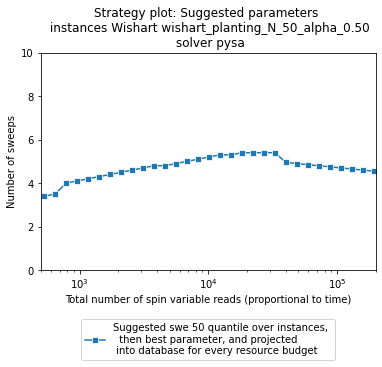

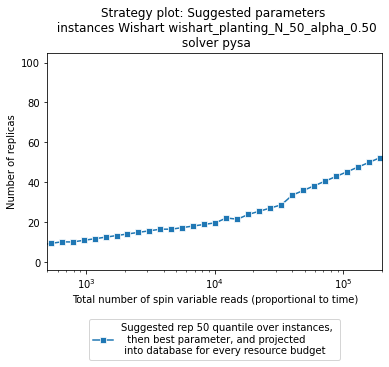

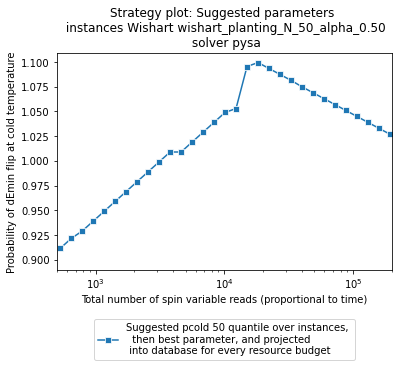

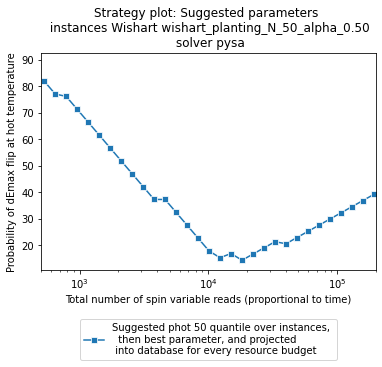

In [15]:
# Strategy Plot: Suggested parameters
if draw_plots:
    # Strategy plot showing how the best parameters change with respect to the resource budget
    for i, parameter_name in enumerate(parameter_names):
        if parameter_name in varying_parameters:
            fig, ax = plt.subplots()
            recipe_smooth = recipe_lazy.set_index('reads').rolling(
                20, min_periods=1).mean().reset_index().copy()
            sns.lineplot(x='reads', y=parameter_name, data=recipe_smooth, ax=ax, estimator=None, label='Suggested ' + parameter_name +
                         ' ' + statistic + ' quantile over instances, \n  then best parameter, and projected \n into database for every resource budget', marker='s')
            if best_tts_param.size > 0 and False:
                plt.axhline(y=best_tts_param[0][i], xmin=0, xmax=1, linestyle='--', color='r',
                            label='Best TTS ' + parameter_name + ' ' + statistic+' quantile over instances')

            # sns.lineplot(x='reads', y=parameter_name, data=recipe_mean_best_params, ax=ax, estimator=None, label='Suggested ' + parameter_name +
            #              '\n best parameters for every instance and resource budget, \n quantile over instances, mean over parameters, \n and projected into database for every read')
            ax.set(xscale='log')
            if parameter_name == 'swe':
                ax.set(ylim=[0,10])
            else:
                # ax.set(ylim=[0,10])
                pass
            ax.set(xlim=[min_plot_reads, max_plot_reads])
            ax.set(ylabel=labels[parameter_name])
            ax.set(xlabel='Total number of spin variable reads (proportional to time)')
            if ocean_df_flag:
                solver = 'dneal'
            else:
                solver = 'pysa'
            ax.set(title='Strategy plot: Suggested parameters \n instances Wishart ' +
                   prefix.rsplit('_inst', 1)[0] + '\n solver ' + solver)
            lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                            fancybox=True)
            if save_plots:
                plot_name = parameter_name+'_'+solver + \
                    '_'+str(size)+'_'+statistic+'.png'
                plt.savefig(os.path.join(plots_path, plot_name),
                            bbox_extra_artists=(lgd,), bbox_inches='tight')

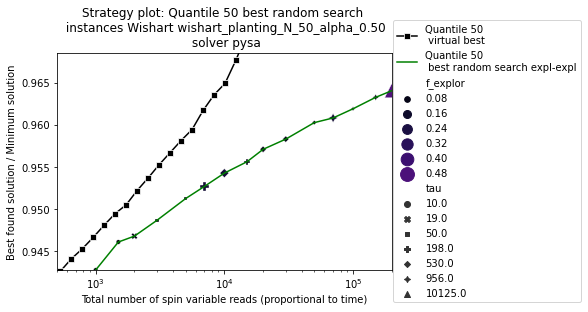

In [16]:
# Strategy Plot: Random search
if draw_plots:
    # Strategy plot showing how the best hyperparameters of the random search change with respect to the resource budget
    strategy_random = df_progress_best['idxmean_'+statistic+'_perf_ratio'].apply(
        pd.Series)
    strategy_random.columns = ['R_budget', 'R_explor', 'tau']
    strategy_random['f_explor'] = strategy_random['R_explor'] / \
        strategy_random['R_budget']
    strategy_random['mean_perf_ratio'] = df_progress_best['mean_'+statistic+'_perf_ratio']

    f, ax = plt.subplots()
    sns.lineplot(x='reads', y='virt_best_'+statistic+'_perf_ratio', data=df_virtual,
                 ax=ax, estimator=None, label='Quantile '+statistic+'  \n virtual best', marker='s', color='k')
    sns.lineplot(x='R_budget', y='mean_'+statistic+'_perf_ratio', data=df_progress_best,
                 ax=ax, estimator=None, label='Quantile '+statistic+' \n best random search expl-expl', color='g')
    sns.scatterplot(
        data=strategy_random,
        x='R_budget',
        size='f_explor',
        hue='f_explor',
        style='tau',
        y='mean_perf_ratio',
        ax=ax,
        palette='magma',
        hue_norm=(0, 2),
        sizes=(20, 200),
        legend='brief')
    ax.set(xlim=[min_plot_reads, max_plot_reads])
    # ax.set(ylim=[None, 1.0025])
    ax.set(ylim=[df_progress_best['mean_'+statistic+'_perf_ratio'].min(),
           df_progress_best['mean_'+statistic+'_perf_ratio'].max()])
    ax.set(xscale='log')
    ax.set(xlabel='Total number of spin variable reads (proportional to time)')
    # ax.set(ylabel='Performance ratio = \n (random - best found) / (random - min)')
    ax.set(ylabel='Best found solution / Minimum solution')
    ax.set(title='Strategy plot: Quantile '+statistic+' best random search \n instances Wishart ' +
           prefix.rsplit('_inst', 1)[0] + '\n solver ' + solver)
    lgd = ax.legend(loc='center left', bbox_to_anchor=(0.99, 0.5),
                    fancybox=True)
    if save_plots:
        plot_name = 'random_search_'+solver+'_'+str(size)+'_'+statistic+'.png'
        plt.savefig(os.path.join(plots_path, plot_name),
                    bbox_extra_artists=(lgd,), bbox_inches='tight')

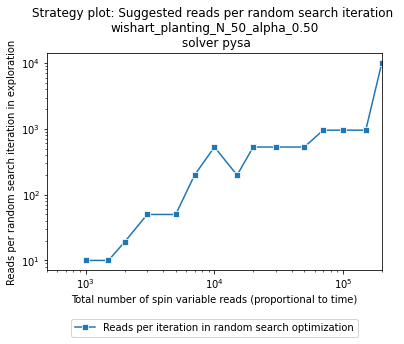

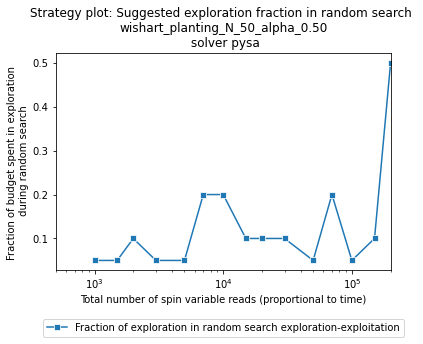

In [17]:
# Strategy Plot: Random search hyperparameters
if draw_plots:
    # Strategy plot showing how the best hyperparameters of the random search change with respect to the resource budget
    f, ax = plt.subplots()
    sns.lineplot(x='R_budget', y='tau', data=strategy_random,
                    ax=ax, estimator=None,
                     label='Reads per iteration in random search optimization', marker='s')

    ax.set(xscale='log')
    ax.set(yscale='log')
    ax.set(xlim=[min_plot_reads, max_plot_reads])
    ax.set(ylabel='Reads per random search iteration in exploration')
    ax.set(xlabel='Total number of spin variable reads (proportional to time)')
    if ocean_df_flag:
        solver = 'dneal'
    else:
        solver = 'pysa'
    ax.set(title='Strategy plot: Suggested reads per random search iteration \n' +
            prefix.rsplit('_inst', 1)[0] + '\n solver ' + solver)
    lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                    fancybox=True)
    if save_plots:
        plot_name = 'random_search_tau_'+solver+'_'+str(size)+'_'+statistic+'.png'
        plt.savefig(os.path.join(plots_path, plot_name),
                    bbox_extra_artists=(lgd,), bbox_inches='tight')


    f, ax = plt.subplots()
    sns.lineplot(x='R_budget', y='f_explor', data=strategy_random,
                    ax=ax, estimator=None,
                     label='Fraction of exploration in random search exploration-exploitation', marker='s')

    ax.set(xscale='log')
    ax.set(xlim=[min_plot_reads, max_plot_reads])
    ax.set(ylabel='Fraction of budget spent in exploration \n during random search')
    ax.set(xlabel='Total number of spin variable reads (proportional to time)')
    if ocean_df_flag:
        solver = 'dneal'
    else:
        solver = 'pysa'
    ax.set(title='Strategy plot: Suggested exploration fraction in random search \n' +
            prefix.rsplit('_inst', 1)[0] + '\n solver ' + solver)
    lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                    fancybox=True)
    if save_plots:
        plot_name = 'random_search_fexpl_'+solver+'_'+str(size)+'_'+statistic+'.png'
        plt.savefig(os.path.join(plots_path, plot_name),
                    bbox_extra_artists=(lgd,), bbox_inches='tight')

# # %%
# # Strategy Plot: Ternary search
# if draw_plots:
#     # Strategy plot showing how the best hyperparameters of the ternary search change with respect to the resource budget
#     strategy_ternary = df_progress_best_ternary['idxmean_'+statistic+'_perf_ratio'].apply(
#         pd.Series)
#     strategy_ternary.columns = ['R_budget', 'R_explor', 'tau']
#     strategy_ternary['f_explor'] = strategy_ternary['R_explor'] / \
#         strategy_ternary['R_budget']
#     strategy_ternary['mean_perf_ratio'] = df_progress_best_ternary['mean_' +
#                                                                    statistic+'_perf_ratio']

#     f, ax = plt.subplots()
#     sns.lineplot(x='reads', y='virt_best_'+statistic+'_perf_ratio', data=df_virtual,
#                  ax=ax, estimator=None, label='Quantile '+statistic+'  \n virtual best')
#     sns.lineplot(x='R_budget', y='mean_'+statistic+'_perf_ratio', data=df_progress_best_ternary,
#                  ax=ax, estimator=None, label='Quantile '+statistic+'  \n best ternary search expl-expl')
#     sns.scatterplot(
#         data=strategy_ternary,
#         x='R_budget',
#         size='f_explor',
#         hue='f_explor',
#         style='tau',
#         y='mean_perf_ratio',
#         ax=ax,
#         palette='magma',
#         hue_norm=(0, 2),
#         sizes=(20, 200),
#         legend='brief')
#     ax.set(xlim=[5e3, 1e6])
#     ax.set(ylim=[0.99, 1.00025])
#     ax.set(xscale='log')
#     ax.set(title='Strategy plot: Quantile '+statistic+' ternary search \n instances Wishart ' +
#            prefix.rsplit('_inst', 1)[0] + '\n solver ' + solver)
#     ax.set(xlabel='Total number of spin variable reads (proportional to time)')
#     ax.set(ylabel='Performance ratio = \n (random - best found) / (random - min)')
#     lgd = ax.legend(loc='center left', bbox_to_anchor=(0.99, 0.5),
#                     fancybox=True)
#     if save_plots:
#         plot_name = 'ternary_search_'+solver+'_'+str(size)+'_'+statistic+'.png'
#         plt.savefig(os.path.join(plots_path, plot_name),
#                     bbox_extra_artists=(lgd,), bbox_inches='tight')

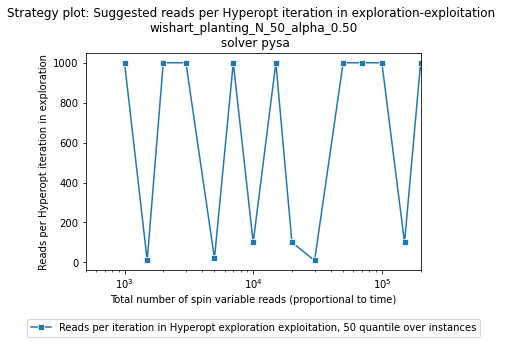

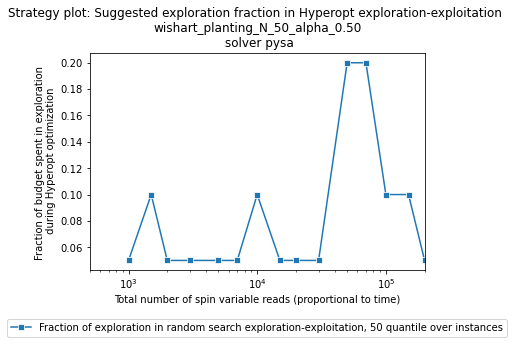

In [18]:
# Strategy Plot: Hyperopt exploration-exploitation
if draw_plots:
    # Strategy plot showing how the best parameters change with respect to the resource budget
    if os.path.exists(hyperopt_expl_path):
        hyperopt_expl_expl = pd.read_pickle(hyperopt_expl_path)
        hyperopt_expl_expl[['tau','f_expl']] = pd.DataFrame(hyperopt_expl_expl['id_best_perf_ratio_'+str(float(statistic)/100)].tolist(), index=hyperopt_expl_expl.index)

        fig, ax = plt.subplots()
        sns.lineplot(x='R_budget', y='tau', data=hyperopt_expl_expl, ax=ax, estimator=None,
                     label='Reads per iteration in Hyperopt exploration exploitation, ' + statistic + ' quantile over instances', marker='s')

        ax.set(xscale='log')
        # ax.set(ylim=[0.98,1.001])
        ax.set(xlim=[min_plot_reads,max_plot_reads])
        ax.set(ylabel='Reads per Hyperopt iteration in exploration')
        ax.set(xlabel='Total number of spin variable reads (proportional to time)')
        ax.set(title='Strategy plot: Suggested reads per Hyperopt iteration in exploration-exploitation \n' +
               prefix.rsplit('_inst', 1)[0] + '\n solver ' + solver)
        lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                        fancybox=True)
        if save_plots:
            plot_name = 'hyperopt_expl_tau_'+solver + \
                '_'+str(size)+'_'+statistic+'.png'
            plt.savefig(os.path.join(plots_path, plot_name),
                        bbox_extra_artists=(lgd,), bbox_inches='tight')



        fig, ax = plt.subplots()
        sns.lineplot(x='R_budget', y='f_expl', data=hyperopt_expl_expl, ax=ax, estimator=None,
                     label='Fraction of exploration in random search exploration-exploitation, ' + statistic + ' quantile over instances', marker='s')

        ax.set(xscale='log')
        # ax.set(ylim=[0.98,1.001])
        ax.set(xlim=[min_plot_reads,max_plot_reads])
        ax.set(ylabel='Fraction of budget spent in exploration \n during Hyperopt optimization')
        ax.set(xlabel='Total number of spin variable reads (proportional to time)')
        ax.set(title='Strategy plot: Suggested exploration fraction in Hyperopt exploration-exploitation \n' +
               prefix.rsplit('_inst', 1)[0] + '\n solver ' + solver)
        lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                        fancybox=True)
        if save_plots:
            plot_name = 'hyperopt_expl_fexpl_'+solver + \
                '_'+str(size)+'_'+statistic+'.png'
            plt.savefig(os.path.join(plots_path, plot_name),
                        bbox_extra_artists=(lgd,), bbox_inches='tight')

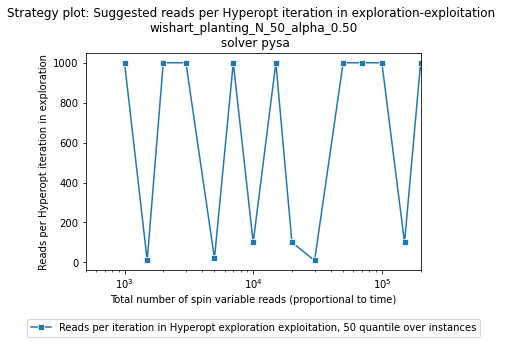

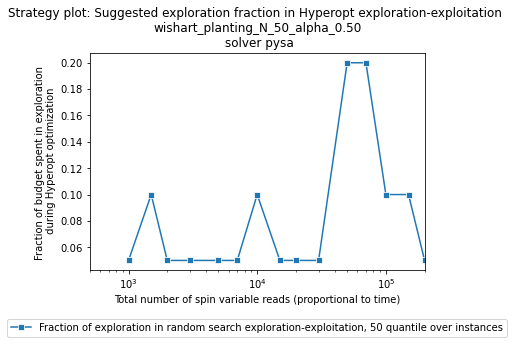

In [20]:
# Strategy Plot: Hyperopt exploration-exploitation
if draw_plots:
    # Strategy plot showing how the best parameters change with respect to the resource budget
    if os.path.exists(hyperopt_expl_path):
        hyperopt_expl_expl = pd.read_pickle(hyperopt_expl_path)
        hyperopt_expl_expl[['tau','f_expl']] = pd.DataFrame(hyperopt_expl_expl['id_best_perf_ratio_'+str(float(statistic)/100)].tolist(), index=hyperopt_expl_expl.index)

        fig, ax = plt.subplots()
        sns.lineplot(x='R_budget', y='tau', data=hyperopt_expl_expl, ax=ax, estimator=None,
                     label='Reads per iteration in Hyperopt exploration exploitation, ' + statistic + ' quantile over instances', marker='s')

        ax.set(xscale='log')
        # ax.set(ylim=[0.98,1.001])
        ax.set(xlim=[min_plot_reads,max_plot_reads])
        ax.set(ylabel='Reads per Hyperopt iteration in exploration')
        ax.set(xlabel='Total number of spin variable reads (proportional to time)')
        ax.set(title='Strategy plot: Suggested reads per Hyperopt iteration in exploration-exploitation \n' +
               prefix.rsplit('_inst', 1)[0] + '\n solver ' + solver)
        lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                        fancybox=True)
        if save_plots:
            plot_name = 'hyperopt_expl_tau_'+solver + \
                '_'+str(size)+'_'+statistic+'.png'
            plt.savefig(os.path.join(plots_path, plot_name),
                        bbox_extra_artists=(lgd,), bbox_inches='tight')



        fig, ax = plt.subplots()
        sns.lineplot(x='R_budget', y='f_expl', data=hyperopt_expl_expl, ax=ax, estimator=None,
                     label='Fraction of exploration in random search exploration-exploitation, ' + statistic + ' quantile over instances', marker='s')

        ax.set(xscale='log')
        # ax.set(ylim=[0.98,1.001])
        ax.set(xlim=[min_plot_reads,max_plot_reads])
        ax.set(ylabel='Fraction of budget spent in exploration \n during Hyperopt optimization')
        ax.set(xlabel='Total number of spin variable reads (proportional to time)')
        ax.set(title='Strategy plot: Suggested exploration fraction in Hyperopt exploration-exploitation \n' +
               prefix.rsplit('_inst', 1)[0] + '\n solver ' + solver)
        lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                        fancybox=True)
        if save_plots:
            plot_name = 'hyperopt_expl_fexpl_'+solver + \
                '_'+str(size)+'_'+statistic+'.png'
            plt.savefig(os.path.join(plots_path, plot_name),
                        bbox_extra_artists=(lgd,), bbox_inches='tight')

# # %%
# # Strategy Plot: Hyperopt search
# if draw_plots:
#     # Strategy plot showing how the best parameters change with respect to the resource budget
#     if os.path.exists(hyperopt_path):
#         fig, ax = plt.subplots()
#         # recipe_smooth = recipe_lazy.set_index('reads').rolling(
#         # 20, min_periods=1).mean().reset_index().copy()
#         sns.lineplot(x='cum_reads', y='run_reads_'+str(float(statistic)/100), data=hyperopt_trials, ax=ax, estimator=None,
#                      label='Fraction of exploration in random search exploration-exploitation', marker='s')

#         ax.set(xscale='log')
#         ax.set(xlim=[min_plot_reads, max_plot_reads])
#         ax.set(ylabel='Fraction of budget spent in exploration \n during random search')
#         ax.set(xlabel='Total number of spin variable reads (proportional to time)')
#         ax.set(title='Strategy plot: Suggested reads per Hyperopt iteration in search \n' +
#                prefix.rsplit('_inst', 1)[0] + '\n solver ' + solver)
#         lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
#                         fancybox=True)
#         if save_plots:
#             plot_name = 'hyperopt_fexpl_'+solver + \
#                 '_'+str(size)+'_'+statistic+'.png'
#             plt.savefig(os.path.join(plots_path, plot_name),
#                         bbox_extra_artists=(lgd,), bbox_inches='tight')

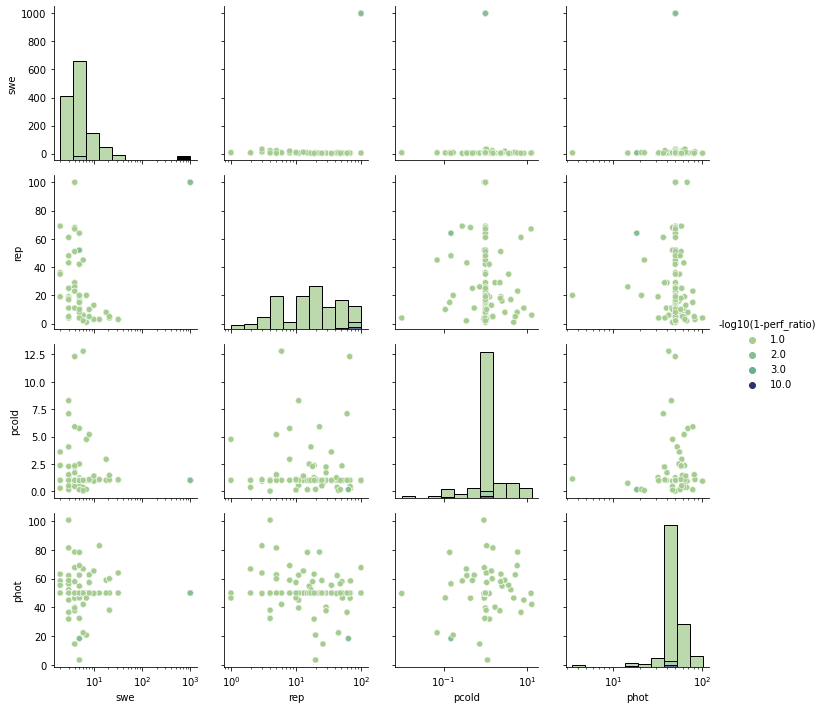

In [21]:
# Data Analysis plot to see correlations among parameters for all the dataset
# Given the amount of data we donwsample only using 1% of all the data to get some general idea of the distribution of the parameters
if draw_plots:
    # sns.pairplot(data=df_stats_interpolated_train[varying_parameters + ['median_perf_ratio']].sample(frac=0.01), hue='median_perf_ratio', palette="crest")
    sample_size = min(int(len(df_stats_interpolated_train)), 500)
    data_analysis_df = df_stats_interpolated_train[varying_parameters + [
        statistic+'_perf_ratio']].sample(n=sample_size)
    if 'Thfactor' in data_analysis_df.columns:
        data_analysis_df['10**Thfactor'] = np.power(
            10, data_analysis_df['Thfactor'])
        data_analysis_df.drop(['Thfactor'], axis=1, inplace=True)

    data_analysis_df['-log10(1-perf_ratio)'] = -np.round(
        np.log10(1-data_analysis_df[statistic+'_perf_ratio']+EPSILON), decimals=0)
    data_analysis_df.drop([statistic+'_perf_ratio'], axis=1, inplace=True)
    g = sns.PairGrid(
        data_analysis_df,
        hue='-log10(1-perf_ratio)',
        palette="crest",
        # diag_sharey=False,
        corner=False,
    )
    # g.map_upper(sns.scatterplot)
    g.map_offdiag(sns.scatterplot)
    # g.map_lower(sns.kdeplot)
    g.map_diag(sns.histplot, multiple="stack",
               bins=10, kde=False, log_scale=True)
    g.add_legend()
    for ax in g.axes.flatten():
        pass
    if save_plots:
        plot_name = 'data_analysis_'+solver+'_'+str(size)+'_'+statistic+'.png'
        plt.savefig(os.path.join(plots_path, plot_name), bbox_inches='tight')

In [22]:
# plt.show()
plt.close()